## Базовые требования к домашкам

1. Формат - jupyter-тетрадка или скрипт на питоне
2. Мы запускаем ваши тетрадки с нуля, поэтому следите, чтобы не было 
- необъявленных переменных (удалили ячейку, а переменная продолжает использоваться)
- лишних принтов отладочной информации
3. Комментарии приветствуются!

## Задание
В рамках этого задания мы будем создавать программу, которая получая на вход отзыв, будет предсказывать, является отзыв положительным или отрицательным. Делать мы будем это таким образом: мы возьмём некоторое число заранее размеченных как положительные или отрицательные отзывов, выделим те слова, которые встречаются только в положительных или только в отрицательных отзывах, и будем считать, каких слов  в поступившем нам на проверку отзыве больше.


Мы будем работать по заранее определённому пайплайну:

### 1. Сбор данных
Сначала нам надо скачать дату -- соберите как минимум 60 (30 положительных  и 30 отрицательных) отзывов на похожие продукты (не надо мешать отзывы на отели с отзывами на ноутбуки) для составления "тонального словаря" (чем больше отзывов, тем лучше)  и 10 отзывов для проверки качества.   (2 балла в случае сбора путём парсинга, 1 - если найдете уже готовые данные или просто закопипастите без парсинга)

В качестве данных я хотел взять отзывы на пиво. Для этого сперва потребуется импортировать всё для работы с сайтами

In [1]:
import urllib.request
import requests
import re
import os
from bs4 import BeautifulSoup

Отзывы я брал в первую очередь с сайта irecommend.ru, он банит соединение буквально через 5 запросов с одного айпи, поэтому мне нужен был прокси. Ниже все импорты, которые я использовал, когда приходилось парсить разные запрещённые сайты. Самое главное, что мне оттуда нужно - игнор ssl сертификата, некоторые прокси без этого не работают, библиотечка FreeProxy, которая берёт рандомный работающий прокси из пула и ошибки, чтобы их обрабатывать, хотя по-моему получилось справиться без них

In [2]:
import traceback
import ssl
import sqlite3
from pprint import pprint
from fake_useragent import UserAgent
from fp.fp import FreeProxy
from requests import ConnectTimeout, HTTPError, Timeout, ConnectionError

from tqdm.auto import tqdm

ssl.SSLContext.verify_mode = ssl.VerifyMode.CERT_OPTIONAL

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

Дальше собираю все ссылки, которые мне нужны и создаю сессию. Ещё один сайт, который я брал - pivobzor.ru, там гораздо меньше обзоров, зато его удобнее парсить. Изначально я планировал ограничиться только им, но мне показалось, что выборка слишком маленькая. Кусок под комментом - как раз оттуда, остальное из irecommend.ru

In [3]:
#urls = [f"https://pivobzor.ru/category/beerreviews/page/{i}/" for i in range(1, 28)]
urls = [f"https://irecommend.ru/catalog/reviews/938-3209"]
urls += [urls[-1]+f"?page={i}" for i in range(101)]

session = requests.session()
session.trust_env = False

Чтобы было, куда записывать данные, нужен датафрейм. В него записываю уникальную ссылку, заголовок, текст и рейтинг. Я использовал разные csv, чтобы хранить результаты с разных сайтов, потом всё сконкатенировал в один, скорее всего код потерялся по пути, заново обкачивать сайты не хочется, это очень долго, если очень хочется, ссылки все сохранились, можно по ним походить

In [4]:
import pandas as pd
from tqdm import tqdm
df = pd.DataFrame(columns=["href", "title", "text", "rating"])

Ниже кусок, которым я парсил irecommend. Выполняется, пока мне не надоест, потому что из-за ошибок ячейка постоянно прерывается. Беру рандомный прокси, если с ним всё ок, то выполняю код, если прокси не нашёлся, пробую ещё раз. Когда нашёл прокси, начинаю проход по всем ссылкам, где вытаскиваю всё, что мне интересно. Закомментил, чтобы при запуске всей тетрадки ничего не взорвалось

In [15]:
"""
while True:
    # берём случайный прокси
    proxy = FreeProxy().get()
    proxies = {
        "https": proxy,
        "http": proxy
    }

    try:
        # если прокси ок
        for url in tqdm(urls):
            # парсим страницу
            req = session.get(url, proxies=proxies)
            page = req.text
            soup = BeautifulSoup(page, 'html.parser')

            # если выкинуло на страницу с тех работами, прокси надо менять, это можно проверить по наличию TextSnippet'a
            if not soup.select('div.reviewTextSnippet a[href]'):
                break

            # если нашёлся, то можно переходить на подстраницы отзывов по адресу в селекте
            for a in tqdm(soup.select('div.reviewTextSnippet a[href]')):
                try:
                    href = "https://irecommend.ru/"+a['href']
                    # проверяем, есть ли ссылка в базе, чтобы экономить время
                    if href in df.href.values:
                        continue

                    # парсим подстраницу
                    sub_req = session.get("https://irecommend.ru/"+a['href'], proxies=proxies)
                    sub_page = sub_req.text
                    sub_soup = BeautifulSoup(sub_page, 'html.parser')

                    # текст собираю по всем <p>
                    text = ""
                    for p in sub_soup.find_all('p'):
                        raw = p.text
                        text += raw.strip()+" "

                    # заголовок для красоты    
                    title = sub_soup.find("h2", {"class": "reviewTitle"}).text
                    # рейтинг напрямую не указан, считаю заполненные звёздочки срели всех звёздочек
                    rating = sum(1 for tag in sub_soup.find_all("div", {"class": "star"})[6:11] if "on" in str(tag))
                    # запихиваю в датафрейм
                    df = pd.concat([df, pd.DataFrame({"href": href, "title": title, "rating": rating, "text": text}, index=[0])])
                    # записываю в csv на всякий случай
                    df.to_csv("beer3.csv")
                except:
                    continue
    except:
        pass


  1%|▊                                                                                 | 1/102 [00:18<31:26, 18.68s/it]

KeyboardInterrupt



In [17]:
df.head()

,href,title,text,rating
0,https://irecommend.ru//content/zvezdatoe-svetl...,\nЗвездатое светлое пиво с модным финским назв...,"Пиво Хейнекен пробовала когда-то в молодости, ...",5
0,https://irecommend.ru//content/obychnyi-evrola...,\nОбычный евролагер с маркетинговым чешским на...,"В сети ""КиБ"" появился новый пивной бренд ""Star...",3
0,https://irecommend.ru//content/obychnaya-balti...,\nОбычная Балтика только более качественная.,Всем привет! Сегодня мой отзыв будет о пиве Pe...,3
0,https://irecommend.ru//content/po-vkusu-pivo-m...,"\nПо вкусу пиво мне понравилось, Оно вкусное, ...",Всем доброго времени суток. В своих предыдущих...,4
0,https://irecommend.ru//content/ocherednoi-vydu...,\nОчередной выдуманный бренд для стран СНГ,На сужающихся от импорта полках крупных сетевы...,3


Всего я обкачал где-то 50 страниц, это занимает очень долгое время из-за прокси. Вышло около 1000 отзывов

Кусок с парсингом pivobzor'a я случайно стёр, но данные с него у меня остались в отдельном датафрейме. Надеюсь, одного парсинга выше хватит, чтобы убедить в том, что я умею это делать

In [5]:
df1 = pd.read_csv("beer1.csv", index_col=0)
df1.head()[["title", "text", "rating"]]

,title,text,rating
0,ABK Hefeweizen АБК Хефевайцен (Германия),"ABK небольшая баварская пивоварня, с очень бол...",7.5
1,Бочонок Для Друзей (Россия),Пусть вас не смущает разница в размере бокала ...,4.8
2,Минское Жигулевское (Беларусь),На этикетке указано что пиво произведено в Бел...,5.2
3,Yelamu Double Ipa Елами Дабл ИПА (Великобритания),Пивоварня Thornbridge не частый гость на росси...,7.5
4,Бергише Ландбир Bergisches Landbier (Германия),Пиво редкое. Производится на маленькой немецко...,7.8


Тогда я ещё не собирал ссылки, но опять же при желании можно всё это просмотреть хотя бы по заголовкам. Рейтинги на том сайте в 10-балльной вещественной шкале, нужно сперва привести к пятибалльной целочисленной

In [6]:
df1.rating = df1.rating.apply(lambda x: round(x/2))

Распределение баллов с pivobzor'a. Как видно, здесь разбиение достаточно разумное

In [7]:
df1.rating.describe()

count    214.000000
mean       2.780374
std        0.926089
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: rating, dtype: float64

Распределение баллов с irecommend. Здесь уже сильный перекос в сторону положительных отзывов, средний балл - около 4

In [8]:
df2 = pd.read_csv("beer2.csv")
df2.rating.describe()

count    1010.000000
mean        3.970297
std         1.218095
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

В следующем файле у меня уже собраны вместе все тексты и там же на самом деле хранится тональность отзыва и обработанный текст, поэтому нигде ниже я специально файл не дописываю. Я уже проследил, чтобы там не было нанов и дубликатов, но при дописывании обязательно надо учесть такой риск 

In [9]:
df = pd.read_csv("beer_data.csv", index_col=0)

Суммарное распределение баллов

In [10]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# код для красивых графиков
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
mpl.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

Text(0.5, 1.0, 'Rating distribution')

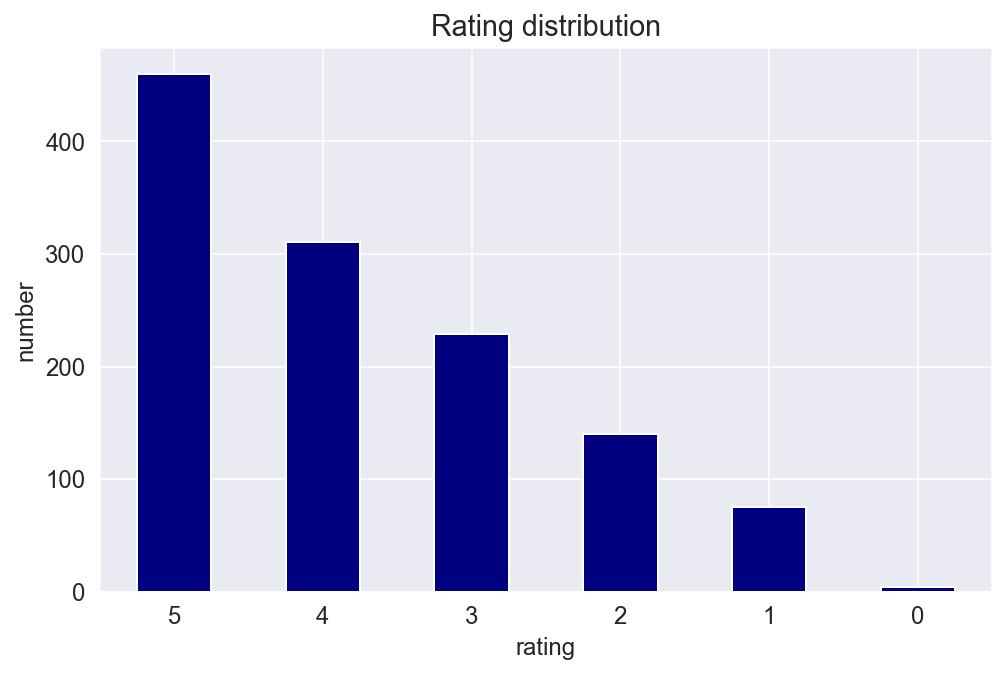

In [11]:
ax = df.rating.value_counts().plot.bar(rot=0, color="navy")
ax.set_xlabel("rating")
ax.set_ylabel("number")
ax.set_title("Rating distribution")

Возникает проблема - на всей выборке средний рейтинг почти, по большей части в целом не опускается ниже 3, судя по первому квартилю

In [12]:
df.rating.describe()

count    1219.000000
mean        3.762100
std         1.255206
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

Поскольку у нас задача бинарной классификации, я решил закодировать всё, что меньше 3, как отрицательный отзыв.

In [13]:
df["sentiment"] = df.rating.apply(lambda x: 1 if x >= 4 else -1)

Text(0.5, 1.0, 'Rating distribution')

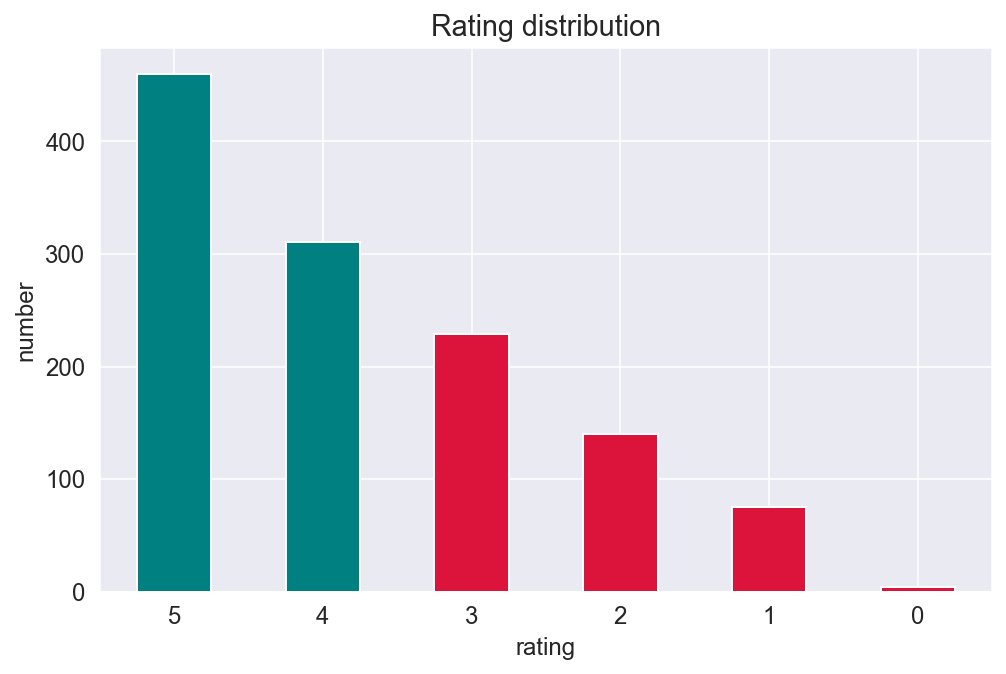

In [14]:
ax = df.rating.value_counts().plot.bar(rot=0, color=["teal"]*2+["crimson"]*4)
ax.set_xlabel("rating")
ax.set_ylabel("number")
ax.set_title("Rating distribution")

В таком случае картина получается уже гораздо лучше

Text(0.5, 1.0, 'Rating distribution')

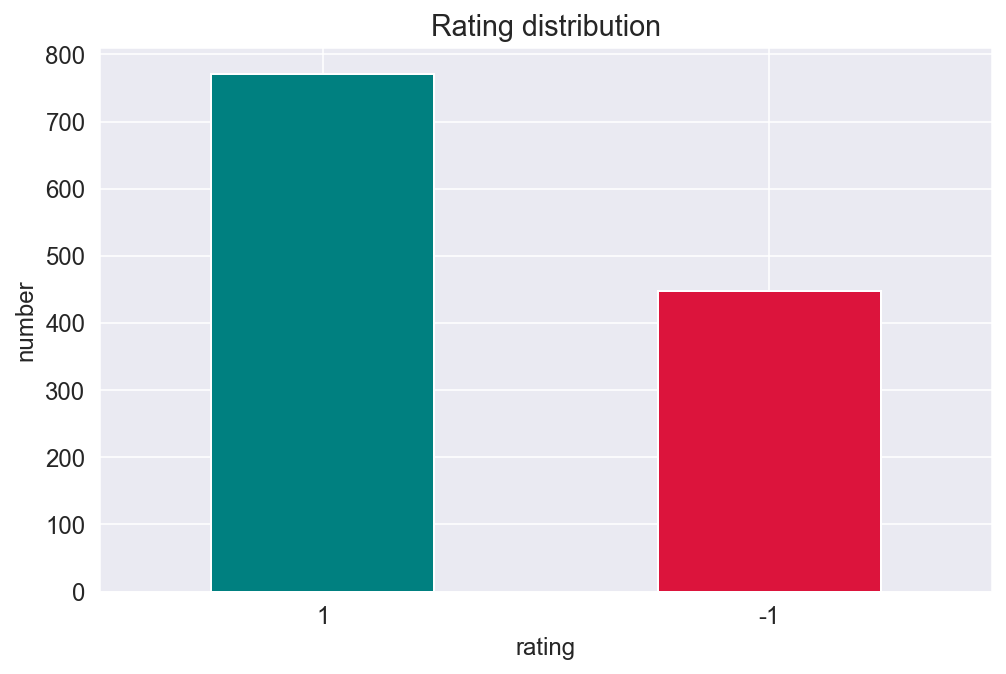

In [15]:
ax = df.sentiment.value_counts().plot.bar(rot=0, color=["teal", "crimson"])
ax.set_xlabel("rating")
ax.set_ylabel("number")
ax.set_title("Rating distribution")

In [16]:
df.sentiment.value_counts(normalize=True)

 1    0.632486
-1    0.367514
Name: sentiment, dtype: float64

Ну и на самом деле отзывы с рейтингом около 3 довольно часто оказываются именно отрицательными, а не просто нейтральными. По крайней мере там часто есть именно критика, просто обычно в более мягкой форме, чем при рейтинге 2 или 1, можно потыкать в следующей ячейке

In [80]:
for i in df[df.rating == 3].text.sample(5):
    print(i[-300:], end="\n\n")

 еще одну банку другой разновидности. Но вдруг то пиво понравиться мне больше. На этом у меня все. Пиво Willianbrau Lager Premium ♥♥♥ Заключение♥♥♥ Пиво Willianbrau Lager Premium– среднее и посредственное пиво. Моя оценка - тройка и не более того. К покупке не рекомендую. С вами была ваша ♥ Неонила 

зводитель прислушается к мнению потребителей и улучшит или "проведет работу над ошибками", ведь массовых российских продуктов(сортов) аналогичных почти нет. Но на сегодняшний этот новый продукт не решает импортозамещение настоящего пилса...Спасибо за внимание и всем новых гастрономических открытий! 

овершенно неважно, какая температура у него будет. Даже в холодном виде, но без газа, карета с гарантией превращается в тыкву, стоит часам пробить полночь. Никакая закуска не может победить этот эффект. Поэтому либо покупайте в банках, а если купили ПЭТ, то подумайте, с кем вы можете им поделиться. 

шь тогда, когда так в охотку захотелось пивка,но вы не слишком требовательны.  В общем, для не

### 2. Процессинг данных
Токенизируйте слова,  приведите их к нижнему регистру и к начальной форме  (1 балл за токенизацию, 1 - за начальную форму)

Для токенизации я взял обычные инструменты из nltk плюс немного pymorphy

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import pymorphy2
import string

morph = pymorphy2.MorphAnalyzer()
# беру только буквы, без цифр
tokenizer = RegexpTokenizer(r'[^\d\W]+')
russian_stopwords = stopwords.words("russian")

Ниже функция, котоой я превращаю отдельный текст в список лемм, от пунктуации чистить токенайзер, от стоп слов чищу сам в функции

In [18]:
def preprocess(text):
    tokens = tokenizer.tokenize(text)
    lemmas = [morph.parse(x)[0].normal_form for x in tokens if x not in russian_stopwords]
    return lemmas

Применяю, получаю список, вношу его в колонку

In [19]:
df["processed"] = df.text.apply(lambda x: preprocess(x))

### 3. Создание словарей для dictionary-based классификации
Составьте 2 множества - в одном будут слова, которые встречаются только в положительных отзывах, а в другом - встречающиеся только в отрицательных. Попробуйте поиграть с частотностями и исключить шум (к примеру, выбросить слова, встречающиеся 1-2 раза) (2 балла) (если у вас получились пустые множества, уберите фильтр по частотности или увеличьте выборку)

Сперва я делю на трейн и тест. Если я хочу получить положительные и отрицательные слова, в идеале они должны быть взяты из трейна, чтобы оценка качества была наиболее правдоподобной

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

y = df.sentiment
X = df.drop("sentiment", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=671, shuffle=True, test_size=10)

Чтобы получить поляризованные слова, нужно сперва взять просто списки слов из соответствующих подмножеств, засунуть их в какой-нибудь хешируемый объект и взять симметрическую разность

In [21]:
def get_words(X_train, y_train):
    # слова берутся для тренировочной подвыборки
    
    # сперва сливаю X и y обратно, чтобы отделить хорошие и плохие отзывы
    concatted = pd.concat([X_train, y_train], axis=1)
    # беру колонку с леммами
    good_words = concatted[concatted.sentiment == 1].processed
    bad_words = concatted[concatted.sentiment == -1].processed
    
    # суммирую, чтобы получить один большой массив, беру каунтер
    good = Counter(good_words.sum())
    bad = Counter(bad_words.sum())

    # беру разность двух множеств и заново заполняю каунтер,
    # при обычной разности будут вычитаться именно каунты, а я хочу их сохранить
    bad_words = Counter({k : bad[k] for k in set(bad) - set(good)})
    good_words = Counter({k : good[k] for k in set(good) - set(bad)})
    
    return good_words, bad_words

In [22]:
good_words, bad_words = get_words(X_train, y_train)

Можно дополнительно исключить слишком частые или слишком редкие слова. Я на самом деле думаю, что совсем исключать их не стоит, но об этом в следующем пункте

In [23]:
good_words_filt = Counter({x: good_words[x] for x in good_words if good_words[x] in range(4, 15)})
bad_words_filt = Counter({x: good_words[x] for x in good_words if good_words[x] in range(4, 15)})

### 4. Простейший классификатор
Создайте функцию, которая будет определять, положительный ли отзыв или отрицательный в зависимости от того, какие слова встретились в нём, и посчитайте качество при помощи accuracy (1  - за коректно работающую функцию, 1 - за подсчёт accuracy)

Я надеюсь, что я правильно понял, что от нас требуется. Если так, то достаточно делает две проверки: прибавлять скор, если слово хорошее, или отнимать. В конце просто возьму максимум между знаком и -1, если положительных слов больше, очевидно он будет 1

In [24]:
def sign(num):
    # не импортировал, потому что 0 я видеть не хочу, а на такое допущение придётся пойти
    # считаем, что нейтральных отзывов не бывает, пока
    return -1 if num <= 0 else 1

In [25]:
def sentiment_prediction(lemmas, gw, bw):
    score = 0
    
    for lemma in lemmas:
        if lemma in gw:
            score += 1
        elif lemma in bw:
            score += -1
            
    return sign(score)

In [26]:
y_pred = X_test.processed.apply(lambda x: sentiment_prediction(x, good_words_filt, bad_words_filt))
accuracy_score(y_pred, y_test)

0.4

Здесь дело в тестовой выборке и в фильтре, как я и говорил

Если взять тестовую выборку нормального размера, то будет видно, что предсказание всё равно довольно грустное. Вспоминаем, что классы у нас несбалансированы, можно было бы брать константный прогноз, было бы не сильно хуже. И по этой же причине на accuracy нет особого смысла смотреть, его не так просто проинтерпретировать, лучше взять рокаук

In [27]:
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=671, shuffle=True, test_size=.3)
good_words, bad_words = get_words(X_train, y_train)
good_words_filt = Counter({x: good_words[x] for x in good_words if good_words[x] in range(4, 15)})
bad_words_filt = Counter({x: good_words[x] for x in good_words if good_words[x] in range(4, 15)})

# фильтр даёт ухудшение качества, кстати, поэтому его нет в описании функции
y_pred = X_test.processed.apply(lambda x: sentiment_prediction(x, good_words, bad_words))
print("accuracy", accuracy_score(y_pred, y_test))
print("roc", roc_auc_score(y_pred, y_test))

accuracy 0.6721311475409836
roc 0.6469750889679715


In [28]:
y_pred = X_test.processed.apply(lambda x: sentiment_prediction(x, good_words_filt, bad_words_filt))
print("accuracy", accuracy_score(y_pred, y_test))
print("roc", roc_auc_score(y_pred, y_test))

accuracy 0.6174863387978142
roc 0.5955063192385707


Ну и итоговый рок тоже весьма пессимситичный, надо дорабатывать модель

### 5. Как сделать лучше

Предложите как минимум 2 способа улучшить эту программу с помощью добавления к ней любых мулек (1 балл за описание словами, 2 - если реализуете хотя бы один способ)

Можно сделать много чего:

1. Выборка не очень большая, вполне возможно, что какие-то "хорошие" или "плохие" слова мы не учли, или учли что-то лишнее, это решается просто - надо скачать побольше. Но возможность того, что слово употреблено в каком-то другом значении остаётся. Решение: взять ещё отзывов, можно докачать irecommend, там остановка где-то на 57 странице, или взять отзывы с otzovika, там тоже наберётся где-то 1000, но с ним та же проблема - опять искать прокси
2. Попробовать улучшить текущий алгоритм. Сейчас в нём никак не учитывается собственно частотность слов. Решение: придумать функцию весов. Я уже говорил выше, что радикальный фильтр мне не очень нравится. Я предполагаю, что самые важные слова действительно имеют среднюю частотность - где-то в районе 10, но остальные тоже сойдут, можно учесть.
3. Получившийся алгоритм слишком простой. Если бы задача была поуже, то может быть словари бы и сработали, но для описания прелести пива используются почти те же самые слова, что и для людей. На самом деле тональность не делится строго бинарно, она может быть смешанная, может быть наполовину негативная и т.д. В таком случае как раз могут помочь рейтинги, которые я тоже собирал, по ним можно построить регрессию и делать не просто оценку тональности, а оценку по 5-балльной шкале. Решение: сделать нормальные эмбеддинги и собрать сложную модель:

    1) попробовать сделать что-то с нграммами, потому что мы учитываем только одно слово, а если перед ним стоит "не"? Тогда это уже не хорошо, надо давать скор в другую сторону, это из банального. Для этого можно обучить w2v, но выборка не очень большая, может и не сработать    
    2) сделать что-нибудь через fasttext, но я не умею, зато он бы (наверное) решил проблему с незнакомыми словами, их тоже довольно много    
    3) обучить какой-нибудь векторайзер из sklearn, выборка вроде бы достаточно большая, чтобы вышло что-то осмысленное, тогда улучшением будет просто подбор гиперпараметров    

Сперва попробуем добавить веса. Я хотел придумать что-нибудь, что будет нормально относится к каунтам близким к 10, сильно обрубать меньший каунт (слишком редкие, чтобы влиять), больший каунт обрубать не так быстро (не знаем точно, стоп-слово или просто частое). Для этого я модифицировал сигмоиду - она почти пологая слева, то, что нужно, прибавил к ней x^2 в знаменателе, чтобы после достижения пика, функция начала убывать примерно как парабола, это не очень быстро с учётом экспоненты, но достаточно, чтобы затухнуть где-то после 20. На графике должно быть достаточно ясно

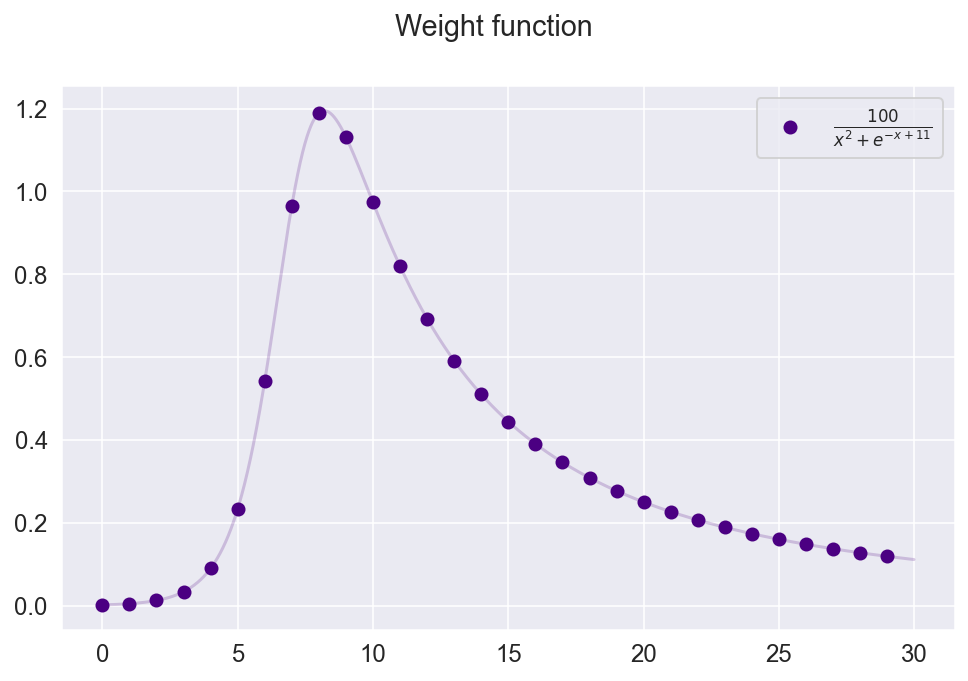

In [29]:
import math
import numpy as np

weight = lambda x: 100 * (1/(x**2 + math.e**(-x+11)))
x_range = range(30)
x_arange = np.arange(0, 30, 0.01)

plt.scatter(x_range, [weight(i) for i in x_range], color="indigo", label=r"""$\frac{100}{x^2 + e^{-x+11}}$""")
plt.plot(x_arange, [weight(i) for i in x_arange], color="indigo", alpha=0.2)
plt.legend()
plt.suptitle("Weight function")
plt.show()

Теперь посмотрим на результат после взвешивания

In [30]:
def weighted_sentiment_prediction(lemmas, gw, bw):
    score = 0
    
    for lemma in lemmas:
        if lemma in gw:
            score += weight(good_words[lemma])
        elif lemma in bw:
            score += -weight(bad_words[lemma])
        
    return sign(score)

In [31]:
y_pred = X_test.processed.apply(lambda x: sentiment_prediction(x, good_words, bad_words))
print("До")
print("accuracy", accuracy_score(y_pred, y_test))
print("roc", roc_auc_score(y_pred, y_test))

До
accuracy 0.6721311475409836
roc 0.6469750889679715


In [33]:
y_pred = X_test.processed.apply(lambda x: weighted_sentiment_prediction(x, good_words, bad_words))
print("После")
print("accuracy", accuracy_score(y_pred, y_test))
print("roc", roc_auc_score(y_pred, y_test))

После
accuracy 0.680327868852459
roc 0.6660231660231659


Результат налицо, но этого всё равно мало. Делать нечего, нужны эмбеддинги. Да и задача понимания рейтинга по тексту гораздо интереснее скучной бинарной классификации, там такая функция точно не сработает. Но сперва разберёмся с классификацией

In [34]:
# возьмём другой таргет

y = df[["rating", "sentiment"]]
X = df.drop(["rating", "sentiment"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=671, shuffle=True, test_size=0.2)

Я довольно долго сидел и подбирал параметры, так что везде, где можно было бы взять друой векторайзер, нормализовать, взять другой гиперпараметр в модели и всё такое прочее - да, можно, но скорее всего будет работать хуже. Ниже оптимальные модели, которые нашёл я

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2))
# важно помнить, что текст у меня в отдельной колонке, из неё нужно собрать новую матрицу
X_train_tfidf = tfidf.fit_transform(X_train.processed.apply(lambda x: " ".join(i for i in x)))
X_test_tfidf = tfidf.transform(X_test.processed.apply(lambda x: " ".join(i for i in x)))

Сперва так или иначе нужно векторизовать. Tfidf в целом даёт результат чуть получше, но будет обучаться гораздо дольше, так что при проверке придётся немного посидеть. В качестве модели я пробовал logreg, svm с разными ядрами и параметрами, random forest, adaboost и наконец catboost. Лучше всего, и приятнее всего работает последний, его даже объяснять особо не надо, я только надеюсь, что картинка не сломается, когда я сдам тетрадку, по-моему она работает только в ноутбуке, если что можно убрать параметр plot и поставить True в verbose

In [ ]:
from catboost import CatBoostRegressor, CatBoostClassifier

# разбираемся с классификацией
model = CatBoostClassifier(max_depth=9, iterations=300, random_state=671, use_best_model=True)
model.fit(X_train_tfidf, y_train.sentiment, plot=True, eval_set=(X_test_tfidf, y_test.sentiment), verbose=False)
y_pred_class = model.predict(X_test_tfidf)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Что в итоге получилось:

In [163]:
y_pred_class = model.predict(X_test_tfidf)

In [165]:
print("accuracy", accuracy_score(y_pred_class, y_test))
print("roc", roc_auc_score(y_pred_class, y_test))

accuracy 0.7623762376237624
roc 0.7367249602543721


In [ ]:
Это уже гораздо лучше, теперь попробуем для рейтинга в целом

In [51]:
from catboost import CatBoostRegressor

# теперь для регрессии
model = CatBoostRegressor(loss_function="RMSE", max_depth=9, iterations=300, random_state=671)
model.fit(X_train_tfidf, y_train.rating, plot=True, eval_set=(X_test_tfidf, y_test.rating), verbose=False)
y_pred_class = model.predict(X_test_tfidf)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [65]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_pred_class, y_test.rating)**(1/2)/5 # беру NRMSE

0.21462765654174776

Если я понимаю, то это означает, что предсказание рейтинга ошибается примерно на 21%. Если так, то это вполне неплохо. Я думаю, что качество можно увеличить ещё больше, сделать RMSE меньше 1, но совсем чуть-чуть. В любом случае мне надоело крутить параметры, скорее всего это максимум, который можно отсюда выжать без нейросеток. Я бы и её состряпал тоже, но мне уже надоело, да и сел я поздновато

Кстати, если потом вернуть всё в бинарное поле, то точность чуть-чуть увеличится

In [75]:
vfunc = np.vectorize(lambda x: -1 if x <=3 else 1)
accuracy_score(vfunc(y_pred_class), y_test.sentiment)

0.7871287128712872

Впрочем, w2v я всё-так обучил, польза от этого сомнительна, потому что я не зафиксировал сид, когда это делал, качество растёт не всегда (почти никогда), чего не скажешь про забавные похожие слова

In [85]:
import gensim

In [4]:
y = df.rating
X = df.drop("rating", axis=1)

In [349]:
w2v = gensim.models.Word2Vec(
            df.processed,
            vector_size=300,
            window=10,
            min_count=2,                                  
            sg = 1,
            hs = 0,
            negative = 5,
            workers= 32,
            seed = 34
)

w2v.train(X_train.processed, total_examples=len(df.processed), epochs=50)

(5614693, 6456400)

In [401]:
w2v.wv.most_similar("алкоголик")

[('начинающий', 0.6352782249450684),
 ('тунеядец', 0.5917229652404785),
 ('кайфовать', 0.5655452609062195),
 ('заядлый', 0.4840172529220581),
 ('вовремя', 0.4807225465774536),
 ('дурной', 0.47416311502456665),
 ('трезвенник', 0.4736362099647522),
 ('coronita', 0.45391443371772766),
 ('пьянство', 0.452775776386261),
 ('опьянить', 0.4485257565975189)]

In [350]:
w2v.wv.most_similar("алкоголик")

[('начинающий', 0.6352782249450684),
 ('тунеядец', 0.5917229652404785),
 ('кайфовать', 0.5655452609062195),
 ('заядлый', 0.4840172529220581),
 ('вовремя', 0.4807225465774536),
 ('дурной', 0.47416311502456665),
 ('трезвенник', 0.4736362099647522),
 ('coronita', 0.45391443371772766),
 ('пьянство', 0.452775776386261),
 ('опьянить', 0.4485257565975189)]

In [351]:
w2v.wv.most_similar("утро")

[('болеть', 0.6070191860198975),
 ('голова', 0.5360240936279297),
 ('гудеть', 0.48447051644325256),
 ('беспамятство', 0.4633532762527466),
 ('сушняк', 0.4494900405406952),
 ('похмелие', 0.4483410716056824),
 ('головной', 0.42831090092658997),
 ('разболеться', 0.42787936329841614),
 ('перебрать', 0.4233745038509369),
 ('синдром', 0.4197368323802948)]

In [352]:
w2v.wv.most_similar("пятница")

[('бухнуть', 0.5462390780448914),
 ('сивуха', 0.46542614698410034),
 ('завозить', 0.43887805938720703),
 ('oеttinger', 0.4273475110530853),
 ('покупалко', 0.41774946451187134),
 ('закупать', 0.4136072099208832),
 ('возить', 0.41059452295303345),
 ('финансы', 0.390547513961792),
 ('ларёк', 0.3849930763244629),
 ('же', 0.3841054141521454)]

Для того, чтобы от ворд2века что-то получить, нужно написать много букв, которые сделают мне векторы из отдельного текста. Это не оригинальный код, но за несколько тетрадок его источник потерялся, в любом случае идейно он не очень сложный

In [402]:
def get_feature_vec(words, model, num_features):
    # сначала нулевой вектор
    feature_vec = np.zeros(num_features, dtype="float32")
    word_num = 0
    
    # сет для скорости
    index2key = set(model.wv.index_to_key)
    
    # для всех слов в тексте
    for word in words:
        if word in index2key:
            # если слово есть в словаре, увеличиваем каунт и компоненту вектора
            word_num += 1
            feature_vec = np.add(feature_vec, model.wv[word])
    
    # нормализую по количеству слов
    feature_vec = np.divide(feature_vec, word_num)
    return feature_vec

In [403]:
def get_avg_vec(texts, model, num_features):
    counter = 0
    # сначала нулевая матрица
    text_feature_vecs = np.zeros((len(texts),num_features),dtype="float32")
    
    # для каждого отдельного текста в выборке
    for text in texts:
        # потихоньку заполняю матрицу векторами-текстами
        text_feature_vecs[counter] = get_feature_vec(text, model, num_features)
        # итерируемся по строкам
        counter = counter+1
        
    return text_feature_vecs

In [404]:
# нужна отдельная матрица векторов-текстов, собираю из колонки, потом применяю w2v к каждому тексту
train_data = [x for x in X_train.processed]
train_data_vecs = np.nan_to_num(get_avg_vec(train_data, w2v, 300))

test_data = [x for x in X_test.processed]
test_data_vecs = np.nan_to_num(get_avg_vec(test_data, w2v, 300))

In [428]:
from catboost import CatBoostRegressor

# теперь для регрессии
w2v_model = CatBoostRegressor(loss_function="RMSE", max_depth=9, iterations=100, random_state=671)
w2v_model.fit(train_data_vecs, y_train.rating, plot=True, eval_set=(test_data_vecs, y_test.rating), verbose=False)
y_pred_class = w2v_model.predict(testDataVecs)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


KeyboardInterrupt



Дальше встаёт вопрос - а зачем я вообще всё это делал? Не знаю, но это был интересный опыт. Она не очень полезна, но если очень хочется, можно переводить буквенные отзывы в циферки, это иногда бывает забавно. Я думаю потом что-нибудь сюда ещё прикрутить. А пока можно оценивать например рекламные ролики и смотреть, насколько они (не)похвалили пиво. На этом всё

In [415]:
pred_text = """В пиве твоя сила и мудрость. Вот, пожалуйста, толстяк. Нормальное пиво. Пацанское, хули
. Пить можно. Ну, как его похвалить, ну, заебись пиво. Пиздатое пиво. Как его ещё похвалить, блядь? Хе-хе.
Невъебенное пиво. Вот оно, жидкое золото!"""

In [421]:
pred_text = """Теперь пиво 'Невское' в новой оригинальной бутылке, но это не имеет никакого значения,
потому что важен только неповторимый, мягкий вкус пива 'Невское', вкус истинного наслаждения.
'Невское', главное - мягкий вкус"""

In [427]:
print(model.predict(tfidf.transform([" ".join(x for x in preprocess(pred_text))])))
w2v_model.predict(tfidf.transform([" ".join(x for x in preprocess(pred_text))]))

[4.18061023]


CatBoostError: There is no trained model to use predict(). Use fit() to train model. Then use this method.

In [423]:
model.predict(get_feature_vec([" ".join(x for x in preprocess(pred_text))], w2v, 300))

C:\Users\Maloy\AppData\Local\Temp\ipykernel_18100\1776108400.py:17: RuntimeWarning: invalid value encountered in true_divide
  feature_vec = np.divide(feature_vec, word_num)


3.876573064292061